# Capillary theory

I propose a theory to explain whether we observe dimple or not in a thin liquid film. The core idea is the dimple is unstable because surface tension always has a tendency to smooth it out. To observe it, the surface tension induced flow has to be sufficiently small, so that the dimple stays longer. 

The dimple formation around a beet slice has two steps:

1. Initial dimple formation due to the suction flow of the beet slice;
2. The smooth-out due to the surface tension induced flow. 

In this notebook, I will model these two steps based on the physical picture depicted above. A simple numerical solution will be presented.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'

0.0 0.0004 -60.0
4.212262048172149e-08 0.00040000000009751956 -59.99933446133463
0.0 0.0004 -60.0
0.0 0.0004000000059604645 -60.00000000029413
0.0 0.0004 -59.99999999941174
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00000000058826
0.0 0.0004 -60.00

Text(0, 0.5, 'Total Volume, $V$ (m$^3$)')

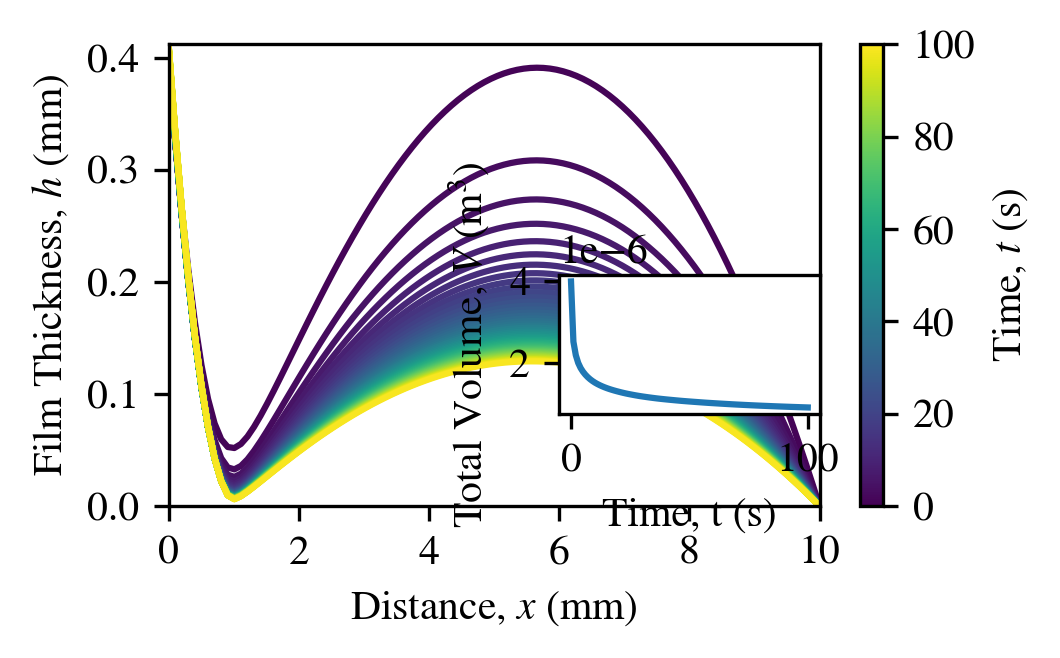

In [20]:
# Physical
sigma = 0.072  # Surface tension (N/m)
mu = 0.01    # Viscosity (Pa.s)
rho = 997     # Density of water (kg/m^3)
g = 9.8       # Gravitational acceleration (m/s^2)


# simulation
T = 100  # Total simulation time (s)
X = 1e-2        # Radius of the domain (m)
N = 100     # Number of radial grid points
x = np.linspace(0, X, N)  # Radial coordinate

# Initial condition
h0 = np.zeros_like(x)  # Initial film thickness profile
h0[:-1] = 4e-4

# free parameters
kappa = 1.2e-7    # Proportionality constant for contact line motion
Pi0 = -60  # Initial pressure at the left boundary (Pa)
theta_s = np.deg2rad(50) # Equilibrium contact angle (degrees)
pore_area = 1.0e-2 # Area of the pores (m^2)

# result plotting
N_curves = 50  # Number of curves to plot

# pre-simulation calculation
V0 = np.trapz(h0, x)

# to debug
h_list = []

def film_drainage(t, y, x, X, rho, g, mu, sigma, theta_s):

    h = y

    dx = (x[2:] - x[:-2]) / 2
    
    p = YL_equation(h, x, sigma)
    
    # Reynolds equation
    dhdt = np.zeros(h.shape)
    h3 =  h**3
    dhdt[1:-1] = 1 / (12 * mu) * ((h3[2:] - h3[:-2]) * (p[2:] - p[:-2]) + 4 * h3[1:-1] * (p[2:] - 2 * p[1:-1] + p[:-2])) / dx**2
    
    # boundary conditions
    U_cl = contact_line_velocity(h, x, sigma, mu, theta_s, kappa=kappa)
    dhdt[-1] = 0
    dhdt[0] = U_cl
    if dhdt.sum() > 0:
        dhdt[0] = 0
    # debug info
    print(t, h[0], p[0])
    return dhdt

def YL_equation(h, x, sigma):

    # Young-Laplace equation
    dx = (x[2:] - x[:-2]) / 2
    p = np.zeros_like(h)
    p[1:-1] = - sigma * (h[2:] - 2 * h[1:-1] + h[:-2]) / dx**2

    # Boundary conditions
    p[0] =  p_left(h, x, V0, Pi0, pore_area)
    p[-1] = p[-2]
    return p

def contact_line_velocity(h, x, sigma, mu, theta_s, kappa=1e-7):
    """
    The contact line motion model of Kim et al. (2017)
    """
    theta = compute_contact_angle_0(h, x)
    U_cl = kappa / mu * sigma * theta * (theta**2 - theta_s**2)
    return U_cl

def compute_contact_angle_0(h, x):
    """
    Calculate the contact angle based on the film thickness profile
    """
    dh = h[2] - h[0]
    dx = x[2] - x[0]

    if dh == 0:
        return np.pi / 2
    else:
        angle = - np.arctan(dx / dh)
        if angle < 0:
            angle += np.pi
        return angle

def p_left(h, x, V0, Pi0, pore_area):
    """
    Calculate the pressure at the left boundary
    """
    # Calculate the total volume of liquid in the domain
    V = np.trapz(h, x)

    # Calculate the pressure at the left boundary
    p = Pi0 + rho * g * (V0 - V) / pore_area
    return p

# Solve the PDE using solve_ivp with the BDF method
t_eval = np.linspace(0, T, 100)
solution = solve_ivp(film_drainage, [0, T], h0, method='BDF', t_eval=t_eval, args=(x, X, rho, g, mu, sigma, theta_s), atol=1e-6, rtol=1e-6)  # BDF method is suitable for stiff problems

# Debugging information
print(f"Number of time steps in solution: {solution.y.shape[1]}")
print(f"Expected number of time steps: {len(t_eval)}")
print(f"Solver message: {solution.message}")

# Check if the solution has the expected number of time steps
if solution.y.shape[1] != len(t_eval):
    raise ValueError(f"Expected {len(t_eval)} time steps, but got {solution.y.shape[1]}")

# Plot the film thickness profile at multiple time steps on the same axis
time_steps = np.linspace(1, len(t_eval)-1, N_curves, dtype=int) # Indices of the time steps to visualize
fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300)
cmap = plt.get_cmap('viridis')
for i in time_steps:
    ax.plot(x*1e3, solution.y[:, i]*1e3, color=cmap(i/len(t_eval)), label=f't = {t_eval[i]:.2f}')

ax.set_xlabel('Distance, $x$ (mm)')
ax.set_ylabel('Film Thickness, $h$ (mm)')
ax.set_xlim(x.min()*1e3, x.max()*1e3)
ax.set_ylim(solution.y.min()*1e3, solution.y.max()*1e3)
# generate a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(t_eval)))
plt.colorbar(sm, ax=ax, label='Time, $t$ (s)')

# Compute the total liquid volume over time
total_volume = np.trapz(solution.y[:], x, axis=0)

# plot total volume in inset
axins = ax.inset_axes([0.6, 0.2, 0.4, 0.3])
axins.plot(t_eval, total_volume)
axins.set_xlabel('Time, t (s)')
axins.set_ylabel('Total Volume, $V$ (m$^3$)')

In [24]:
50 / np.sin(np.deg2rad(20))

146.19022000815437

In [26]:
40e-3 / (150*2e-6)

133.33333333333334